[[ -12. -100.]
 [   1.    0.]] [[1.]
 [0.]] [[  0. 100.]] [[0.]]


C:\Users\claud\AppData\Local\Temp\ipykernel_39832\101103634.py:31: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  return float(beta)


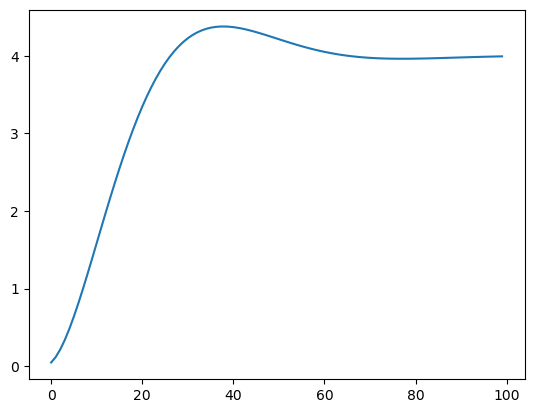

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.signal import cont2discrete, tf2ss

zeta = 0.6
omega_n = 10

# Transfer function coefficients
num = [omega_n**2]
den = [1, 2*zeta*omega_n, omega_n**2]

# Convert TF → State-space
A, B, C, D = tf2ss(num, den)

Ts = 0.01  # sample time

# Now discretize the state-space system
Ad, Bd, Cd, Dd, dt = cont2discrete((A, B, C, D), Ts, method='bilinear')

print(A, B, C, D)
# Initial state
x = np.zeros((2, 1))

def pitch_update(beta_ref):
    global x

    x = Ad @ x + Bd * beta_ref

    beta = Cd @ x + Dd * beta_ref
    return float(beta)

beta_values = []
for k in range(100):
    beta = pitch_update(beta_ref=4.0)   # command pitch = 5 degrees
    beta_values.append(beta)

plt.plot(beta_values)

In [5]:
print(Ad, Bd, Cd, Dd)

[[ 0.88235294 -0.94117647]
 [ 0.00941176  0.99529412]] [[9.41176471e-03]
 [4.70588235e-05]] [[ 0.47058824 99.76470588]] [[0.00235294]]


In [14]:
path = r'TSRxCPxPSI.csv'
df = pd.read_csv(path)
df

,TSR,-5,-4,-3,-2,-1,0,1,2,3,4,5
0,0.411942,0.0007,0.0010,0.0013,0.0015,0.0018,0.0021,0.0023,0.0026,0.0028,0.0031,0.0033
1,0.439404,0.0008,0.0011,0.0014,0.0016,0.0019,0.0022,0.0025,0.0027,0.0030,0.0033,0.0035
2,0.470790,0.0009,0.0012,0.0015,0.0018,0.0021,0.0024,0.0027,0.0030,0.0032,0.0035,0.0038
3,0.507005,0.0009,0.0013,0.0016,0.0019,0.0022,0.0026,0.0029,0.0032,0.0035,0.0038,0.0041
4,0.549255,0.0010,0.0014,0.0017,0.0021,0.0024,0.0028,0.0032,0.0035,0.0038,0.0042,0.0045
...,...,...,...,...,...,...,...,...,...,...,...,...
191,23.068729,-0.5313,-0.5180,-0.5276,-0.5396,-0.5539,-0.5790,-0.6162,-0.6788,-0.8500,-1.1788,-1.7242
192,24.167240,-0.6381,-0.6257,-0.6392,-0.6585,-0.6841,-0.7269,-0.7918,-0.8824,-1.0819,-1.4697,-2.1104
193,26.364261,-0.8841,-0.8743,-0.8973,-0.9319,-0.9832,-1.0642,-1.1895,-1.3443,-1.6264,-2.1537,-3.0514
194,28.561283,-1.1772,-1.1713,-1.2051,-1.2564,-1.3369,-1.4665,-1.6582,-1.9132,-2.2992,-3.0409,-4.1698


In [ ]:
path = r'TSRxCPxPSI.csv'
df = pd.read_csv(path)
angles = np.arange(-5,6,1)
TSR = df.iloc[:,0]

def Cp_calc(LAMBDA=0, PHI=0):
    path = r'TSRxCPxPSI.csv'
    df = pd.read_csv(path)
    angles = np.arange(-5,6,1)
    TSR = df.iloc[:,0]
    diff1 = np.abs(TSR - LAMBDA)
    diff2 = np.abs(angles - PHI)
    id1 = np.argmin(diff1)
    id2 = np.argmin(diff2)+1

    return df.iloc[id1,id2]

Cp_calc(LAMBDA=7.6, PHI=1)

0.4796